In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime as dt 
import matplotlib.pyplot as plt
import pmdarima as pm
import warnings
import optuna
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from sklearn.model_selection import TimeSeriesSplit
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

c:\Users\p0f3h\anaconda3\envs\2024project\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define the ticker symbol for the Shanghai Composite Index
ticker = '000001.SS'

# Define the date range
start_date = '2014-01-01'
end_date = '2024-01-01'

# Download the full dataset sourced from yahoo finance
data = yf.download(ticker, start=start_date, end=end_date)

# Print some samples
print(pd.concat([data.head(1), data.tail(1)]))


[*********************100%%**********************]  1 of 1 completed

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2014-01-02  2112.125977  2113.110107  2101.016113  2109.386963  2109.386963   
2023-12-29  2950.836914  2975.031982  2950.017090  2974.935059  2974.935059   

            Volume  
Date                
2014-01-02   68500  
2023-12-29  290700  


In [3]:
# Define a function for train-test split
def train_test_split(X, size=0.8):
    train = X[:int(X.shape[0]*size)]
    test = X[int(X.shape[0]*size):]
    return train, test

# Split train set and test set
train, test = train_test_split(X=data['Close'], size=0.8)

In [4]:
# Train an ARIMA model using the auto_arima function on the training data
arima_model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)

# Print a summary of the fitted ARIMA model
print(arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=20347.239, Time=1.36 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=20410.570, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=20403.195, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=20401.873, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=20409.129, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=20400.015, Time=0.46 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=20399.015, Time=0.42 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=20326.165, Time=2.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=20394.165, Time=1.05 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=20328.057, Time=1.57 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=20355.667, Time=2.92 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=20327.297, Time=2.50 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=20382.739, Time=0.61 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=20329.444, Time=2.91 sec
 ARIMA(3,1,2)(0,0,0

In [5]:
# Extract residuals from ARIMA model
arima_residuals = arima_model.resid()

# Normalize the data
sc = MinMaxScaler(feature_range=(0, 1))
lstm_data = arima_residuals.values.reshape(-1, 1)  # Get residuals and reshape
sc_data = sc.fit_transform(lstm_data)

In [6]:
# Define function to prepare the data
def prepare_data(seq_len, data):
    X = np.array([data[i:i+seq_len, :] for i in range(data.shape[0] - seq_len)])
    y = np.array([data[i+seq_len, 0] for i in range(data.shape[0] - seq_len)])  # Predicting ARIMA residuals
    return X, y

In [11]:
# Create an SQLite database to store the study
study_name = 'test_ARIMA_LSTM'
storage_name = f'sqlite:///{study_name}.db'

# Create an Optuna study with the SQLite storage
study = optuna.create_study(direction='minimize', storage=storage_name, study_name=study_name, load_if_exists=True)

# Define the objective function for Optuna (same as before)
def objective(trial):
    # Define the hyperparameters to be optimized
    seq_len = trial.suggest_int('seq_len', 2, 10)
    num_layers = trial.suggest_int('num_layers', 1, 3)
    units_list = [trial.suggest_int(f'units_l{i}', 32, 128) for i in range(num_layers)]
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    l2_reg = trial.suggest_float('l2_reg', 1e-5, 1e-2, log=True)
    activation = trial.suggest_categorical('activation', ['linear', 'relu', 'sigmoid'])

    # Fixed batch size and epochs
    batch_size = 32
    epochs = 100

    # Prepare the data using the suggested sequence length
    X_train, y_train = prepare_data(seq_len, sc_data)

    # Create the LSTM model with the suggested hyperparameters
    model = Sequential()

    # First LSTM layer
    model.add(LSTM(units=units_list[0], input_shape=(X_train.shape[1], X_train.shape[2]),
                   return_sequences=(num_layers > 1), kernel_regularizer=l2(l2_reg)))
    model.add(Dropout(dropout_rate))

    # Additional LSTM layers
    for i in range(1, num_layers):
        model.add(LSTM(units=units_list[i], return_sequences=(i < num_layers - 1), kernel_regularizer=l2(l2_reg)))
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1, activation=activation))

    # Compile the model
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Use TimeSeriesSplit for cross-validation
    tscv = TimeSeriesSplit(n_splits=20)
    val_loss_list = []

    for train_index, val_index in tscv.split(X_train):
        X_tr, X_val = X_train[train_index], X_train[val_index]
        y_tr, y_val = y_train[train_index], y_train[val_index]

        # EarlyStopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        # Train the model
        history = model.fit(X_tr, y_tr, validation_data=(X_val, y_val),
                            epochs=epochs, batch_size=batch_size, verbose=0,
                            callbacks=[early_stopping])

        # Get the validation loss
        val_loss = min(history.history['val_loss'])
        val_loss_list.append(val_loss)

    # Return the average validation loss across folds
    return np.mean(val_loss_list)

# Optimize the study
study.optimize(objective, n_trials=50)

[I 2024-08-25 14:16:35,800] A new study created in RDB with name: test_ARIMA_LSTM
[I 2024-08-25 14:17:34,747] Trial 0 finished with value: 0.00035648813736770534 and parameters: {'seq_len': 2, 'num_layers': 1, 'units_l0': 36, 'dropout_rate': 0.17823241563130568, 'l2_reg': 0.0038483756980796165, 'activation': 'linear'}. Best is trial 0 with value: 0.00035648813736770534.
[I 2024-08-25 14:21:34,693] Trial 1 finished with value: 0.0003579256610464654 and parameters: {'seq_len': 10, 'num_layers': 2, 'units_l0': 97, 'units_l1': 81, 'dropout_rate': 0.38771617029518657, 'l2_reg': 0.008605233451741245, 'activation': 'sigmoid'}. Best is trial 0 with value: 0.00035648813736770534.
[I 2024-08-25 14:30:09,598] Trial 2 finished with value: 0.00038115375700726873 and parameters: {'seq_len': 10, 'num_layers': 3, 'units_l0': 67, 'units_l1': 48, 'units_l2': 104, 'dropout_rate': 0.4169962472492079, 'l2_reg': 2.750147980127276e-05, 'activation': 'linear'}. Best is trial 0 with value: 0.000356488137367705

In [14]:
# Load the Optuna study from the SQLite database
study_name='test_ARIMA_LSTM'
storage_name = f'sqlite:///{study_name}.db'
study = optuna.load_study(study_name=study_name, storage=storage_name)

# Extract the best trial's hyperparameters
best_trial = study.best_trial
seq_len = best_trial.params['seq_len']
layers = best_trial.params['num_layers']
dropout_rate = best_trial.params['dropout_rate']
l2_reg = best_trial.params['l2_reg']
activation = best_trial.params['activation']

# Extract units for each layer based on the number of layers
units = [best_trial.params[f'units_l{i}'] for i in range(layers)]

# Fixed parameters
epochs = 100
batch_size = 32

# Prepare data for LSTM model using the best sequence length
X_train, y_train = prepare_data(seq_len, sc_data)

print(X_train.shape, y_train.shape)

# Define the LSTM model with optimal hyperparameters
model = Sequential()

# First LSTM layer with return_sequences=True if layers > 1
model.add(LSTM(units=units[0], input_shape=(X_train.shape[1], X_train.shape[2]), 
               return_sequences=(layers > 1), kernel_regularizer=l2(l2_reg)))
model.add(Dropout(dropout_rate))  # Dropout layer

# If there are multiple layers, add more LSTM and Dropout layers
for i in range(1, layers):
    model.add(LSTM(units=units[i], return_sequences=(i < layers - 1), kernel_regularizer=l2(l2_reg)))
    model.add(Dropout(dropout_rate))  # Dropout layer

# Output layer with the specified activation function
model.add(Dense(1, activation=activation))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Model summary
model.summary()

(1934, 10, 1) (1934,)
Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_128 (LSTM)             (None, 10, 91)            33852     
                                                                 
 dropout_127 (Dropout)       (None, 10, 91)            0         
                                                                 
 lstm_129 (LSTM)             (None, 10, 110)           88880     
                                                                 
 dropout_128 (Dropout)       (None, 10, 110)           0         
                                                                 
 lstm_130 (LSTM)             (None, 96)                79488     
                                                                 
 dropout_129 (Dropout)       (None, 96)                0         
                                                                 
 dense_51 (Dense)            (N

In [15]:
# Print the best trial's value (objective value)
print(f"Best trial value (loss): {best_trial.value}")

# Print the hyperparameters of the best trial
print("Best trial hyperparameters:")
for param_name, param_value in best_trial.params.items():
    print(f"  {param_name}: {param_value}")

Best trial value (loss): 0.0003550974213794689
Best trial hyperparameters:
  seq_len: 10
  num_layers: 3
  units_l0: 91
  units_l1: 110
  units_l2: 96
  dropout_rate: 0.26026853223593993
  l2_reg: 0.003383382063123103
  activation: relu


In [16]:
# Suppress specific warning messages
warnings.filterwarnings("ignore", category=UserWarning, module='statsmodels')

Epoch 1/100
49/49 - 18s - loss: 0.7028 - val_loss: 0.3313 - 18s/epoch - 372ms/step
Epoch 2/100
49/49 - 3s - loss: 0.2057 - val_loss: 0.1086 - 3s/epoch - 58ms/step
Epoch 3/100
49/49 - 3s - loss: 0.0788 - val_loss: 0.0478 - 3s/epoch - 59ms/step
Epoch 4/100
49/49 - 3s - loss: 0.0418 - val_loss: 0.0265 - 3s/epoch - 58ms/step
Epoch 5/100
49/49 - 3s - loss: 0.0267 - val_loss: 0.0169 - 3s/epoch - 63ms/step
Epoch 6/100
49/49 - 3s - loss: 0.0189 - val_loss: 0.0114 - 3s/epoch - 53ms/step
Epoch 7/100
49/49 - 3s - loss: 0.0157 - val_loss: 0.0094 - 3s/epoch - 53ms/step
Epoch 8/100
49/49 - 3s - loss: 0.0132 - val_loss: 0.0072 - 3s/epoch - 69ms/step
Epoch 9/100
49/49 - 3s - loss: 0.0120 - val_loss: 0.0064 - 3s/epoch - 71ms/step
Epoch 10/100
49/49 - 3s - loss: 0.0109 - val_loss: 0.0062 - 3s/epoch - 67ms/step
Epoch 11/100
49/49 - 3s - loss: 0.0106 - val_loss: 0.0067 - 3s/epoch - 68ms/step
Epoch 12/100
49/49 - 3s - loss: 0.0103 - val_loss: 0.0051 - 3s/epoch - 66ms/step
Epoch 13/100
49/49 - 3s - loss: 0.

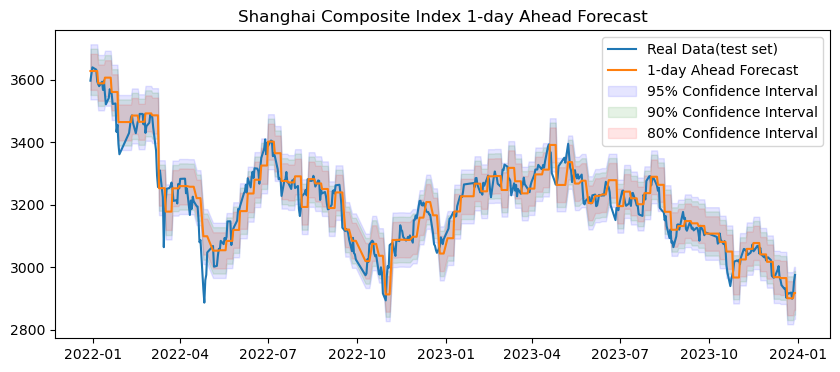

Epoch 1/100
49/49 - 4s - loss: 0.0076 - val_loss: 0.0041 - 4s/epoch - 80ms/step
Epoch 2/100
49/49 - 4s - loss: 0.0076 - val_loss: 0.0041 - 4s/epoch - 74ms/step
Epoch 3/100
49/49 - 4s - loss: 0.0077 - val_loss: 0.0041 - 4s/epoch - 74ms/step
Epoch 4/100
49/49 - 4s - loss: 0.0076 - val_loss: 0.0041 - 4s/epoch - 74ms/step
Epoch 5/100
49/49 - 4s - loss: 0.0076 - val_loss: 0.0041 - 4s/epoch - 73ms/step
Epoch 6/100
49/49 - 4s - loss: 0.0076 - val_loss: 0.0041 - 4s/epoch - 74ms/step
Epoch 7/100
49/49 - 4s - loss: 0.0076 - val_loss: 0.0041 - 4s/epoch - 73ms/step
Epoch 8/100
49/49 - 4s - loss: 0.0076 - val_loss: 0.0041 - 4s/epoch - 72ms/step
Epoch 9/100
49/49 - 4s - loss: 0.0076 - val_loss: 0.0041 - 4s/epoch - 82ms/step
Epoch 10/100
49/49 - 5s - loss: 0.0076 - val_loss: 0.0041 - 5s/epoch - 96ms/step
Epoch 11/100
49/49 - 5s - loss: 0.0076 - val_loss: 0.0041 - 5s/epoch - 95ms/step
Epoch 12/100
49/49 - 5s - loss: 0.0077 - val_loss: 0.0041 - 5s/epoch - 96ms/step
Epoch 13/100
49/49 - 5s - loss: 0.007

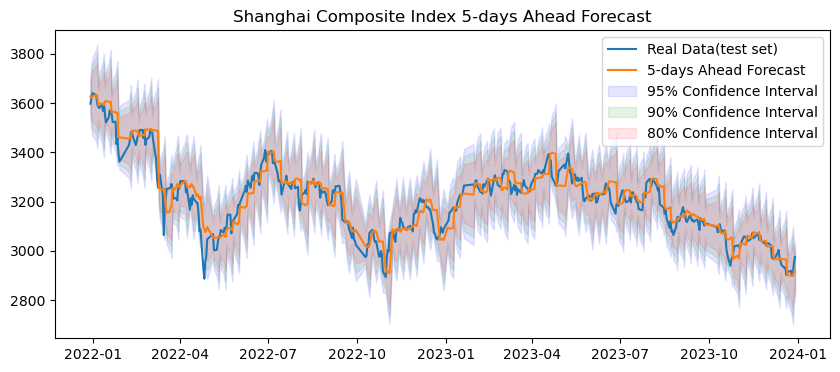

Epoch 1/100
49/49 - 6s - loss: 0.0076 - val_loss: 0.0041 - 6s/epoch - 130ms/step
Epoch 2/100
49/49 - 6s - loss: 0.0076 - val_loss: 0.0041 - 6s/epoch - 128ms/step
Epoch 3/100
49/49 - 6s - loss: 0.0076 - val_loss: 0.0041 - 6s/epoch - 130ms/step
Epoch 4/100
49/49 - 6s - loss: 0.0076 - val_loss: 0.0041 - 6s/epoch - 129ms/step
Epoch 5/100
49/49 - 6s - loss: 0.0076 - val_loss: 0.0041 - 6s/epoch - 119ms/step
Epoch 6/100
49/49 - 5s - loss: 0.0076 - val_loss: 0.0041 - 5s/epoch - 101ms/step
Epoch 7/100
49/49 - 5s - loss: 0.0076 - val_loss: 0.0041 - 5s/epoch - 104ms/step
Epoch 8/100
49/49 - 5s - loss: 0.0076 - val_loss: 0.0041 - 5s/epoch - 102ms/step
Epoch 9/100
49/49 - 5s - loss: 0.0076 - val_loss: 0.0041 - 5s/epoch - 101ms/step
Epoch 10/100
49/49 - 5s - loss: 0.0076 - val_loss: 0.0041 - 5s/epoch - 102ms/step
Epoch 11/100
49/49 - 5s - loss: 0.0076 - val_loss: 0.0041 - 5s/epoch - 102ms/step
1/1 [==============================] - 0s 65ms/step
Epoch 1/100
50/50 - 7s - loss: 0.0077 - val_loss: 0.003

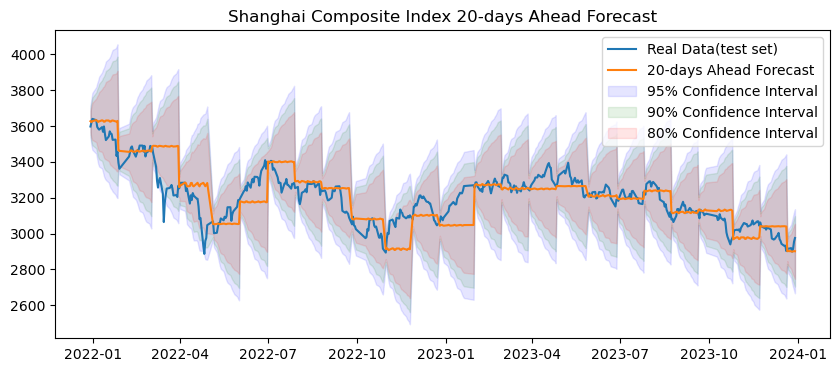

Epoch 1/100
49/49 - 4s - loss: 0.0076 - val_loss: 0.0041 - 4s/epoch - 78ms/step
Epoch 2/100
49/49 - 4s - loss: 0.0076 - val_loss: 0.0041 - 4s/epoch - 78ms/step
Epoch 3/100
49/49 - 4s - loss: 0.0076 - val_loss: 0.0041 - 4s/epoch - 79ms/step
Epoch 4/100
49/49 - 4s - loss: 0.0076 - val_loss: 0.0041 - 4s/epoch - 79ms/step
Epoch 5/100
49/49 - 4s - loss: 0.0076 - val_loss: 0.0041 - 4s/epoch - 78ms/step
Epoch 6/100
49/49 - 4s - loss: 0.0076 - val_loss: 0.0041 - 4s/epoch - 78ms/step
1/1 [==============================] - 0s 40ms/step
Epoch 1/100
52/52 - 4s - loss: 0.0076 - val_loss: 0.0041 - 4s/epoch - 80ms/step
Epoch 2/100
52/52 - 4s - loss: 0.0076 - val_loss: 0.0041 - 4s/epoch - 83ms/step
Epoch 3/100
52/52 - 4s - loss: 0.0076 - val_loss: 0.0041 - 4s/epoch - 84ms/step
Epoch 4/100
52/52 - 5s - loss: 0.0076 - val_loss: 0.0041 - 5s/epoch - 93ms/step
Epoch 5/100
52/52 - 5s - loss: 0.0076 - val_loss: 0.0041 - 5s/epoch - 88ms/step
Epoch 6/100
52/52 - 5s - loss: 0.0076 - val_loss: 0.0041 - 5s/epoch 

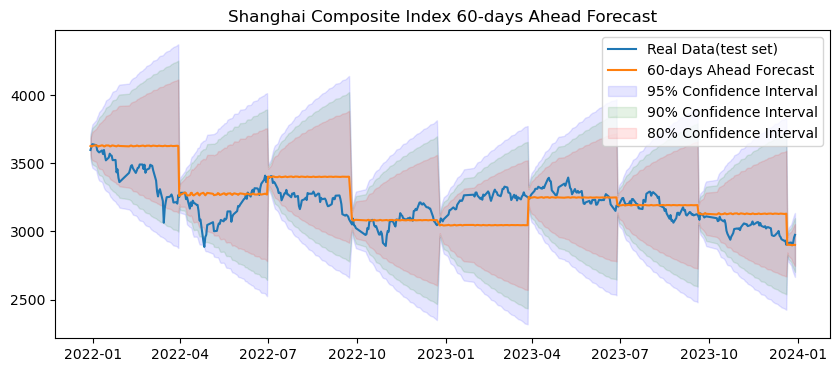

1-day Ahead Forecast:
MAE: 36.6769616338432
RMSE: 49.80646021473778
MAPE: 1.1515114196771643%

5-days Ahead Forecast:
MAE: 36.72960147443174
RMSE: 49.63755984265851
MAPE: 1.152493855702819%

20-days Ahead Forecast:
MAE: 69.44897719406362
RMSE: 97.01462606220865
MAPE: 2.1850101712135923%

60-days Ahead Forecast:
MAE: 113.47342146260476
RMSE: 146.75318944579251
MAPE: 3.5475381548227514%



In [17]:
# Function to perform forecast with specific confidence level
def one_step_forecast(n_periods=1, alpha=0.05):
    arima_forecast, conf_int = arima_model.predict(n_periods=n_periods, return_conf_int=True, alpha=alpha)
    
    # Prepare the input for LSTM model from the last residuals
    last_residuals = arima_model.resid()[-seq_len:]
    
    lstm_forecasts = []
    
    for _ in range(n_periods):
        # Convert last_residuals to numpy array and reshape
        last_residuals_np = last_residuals.values.reshape(1, seq_len, 1)

        last_residuals_scaled = sc.transform(last_residuals_np.reshape(-1, 1)).reshape(1, seq_len, 1)

        # Predict the next residual with LSTM model
        lstm_forecast_scaled = model.predict(last_residuals_scaled)[0, 0]
        lstm_forecast = sc.inverse_transform([[lstm_forecast_scaled]])[0, 0]
        
        lstm_forecasts.append(lstm_forecast)
        
        # Update last_residuals with the new forecasted residual using pd.concat
        last_residuals = pd.concat([last_residuals, pd.Series([lstm_forecast])]).iloc[-seq_len:]

    return (
        arima_forecast.tolist()[:n_periods],
        np.asarray(conf_int).tolist()[:n_periods],
        lstm_forecasts
    )

# Function to retrain the LSTM model
def retrain_lstm(residuals):
    # Replace the first residual
    residuals.iloc[0] = np.mean(residuals[1:])
    
    lstm_data = residuals.values.reshape(-1, 1)
    sc_data = sc.fit_transform(lstm_data)
    X_train = np.array([sc_data[i : i + seq_len, :] for i in range(sc_data.shape[0] - seq_len)])
    y_train = np.array([sc_data[i + seq_len, 0] for i in range(sc_data.shape[0] - seq_len)])
    
    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=2, validation_split=0.2, callbacks=[early_stopping])

# Define a function for re-estimating ARIMA model with new data
def reestimate_arima_model(train_data):
    return auto_arima(train_data, trace=False, error_action='ignore', suppress_warnings=True)

# Perform forecasts and evaluations for different periods
forecast_periods = {'1-day': 1, '5-days': 5, '20-days': 20, '60-days': 60}
results = {}

for period_name, n_periods in forecast_periods.items():
    # Creat empty lists for storing results
    arima_predictions = []
    confidence_intervals_95 = []
    confidence_intervals_90 = []
    confidence_intervals_80 = []
    lstm_predictions = []
    # Define the ARIMA model and LSTM model for each time horizon
    current_train = train.copy()
    arima_model = reestimate_arima_model(current_train)
    retrain_lstm(arima_model.resid())
    # For daily forecast, we choose to re-estimate parameters every 5 forecasts
    reestimate_interval = 5 if period_name == '1-day' else 1
    forecasts_since_last_reestimate = 0
    
    for i in range(0, len(test), n_periods):
        # Perform forecast
        arima_forecast_95, conf_95, lstm_forecast = one_step_forecast(n_periods=n_periods, alpha=0.05)
        arima_forecast_90, conf_90, _ = one_step_forecast(n_periods=n_periods, alpha=0.10)
        arima_forecast_80, conf_80, _ = one_step_forecast(n_periods=n_periods, alpha=0.20)

        for j in range(n_periods):
            if i + j < len(test):
                # Store results
                arima_predictions.append(arima_forecast_95[j])
                confidence_intervals_95.append(conf_95[j])
                confidence_intervals_90.append(conf_90[j])
                confidence_intervals_80.append(conf_80[j])
                lstm_predictions.append(lstm_forecast[j])  
                
        # Update the training sets with new observed data
        current_train = pd.concat([current_train, test[i:i+n_periods]])
        
        
        # Re-estimate the ARIMA model with the updated training sets
        forecasts_since_last_reestimate += 1
        if forecasts_since_last_reestimate >= reestimate_interval:
            arima_model = reestimate_arima_model(current_train)
            forecasts_since_last_reestimate = 0
            
        # Retrain the LSTM model based on the forecast period
        if period_name == '1-day' and (i + n_periods) % 5 == 0:
            retrain_lstm(arima_model.resid())
        elif period_name == '5-days' and (i + n_periods) % (5 * 2) == 0:  
            retrain_lstm(arima_model.resid())
        elif period_name == '20-days' and (i + n_periods) % (20 * 2) == 0:  
            retrain_lstm(arima_model.resid())
        elif period_name == '60-days' and (i + n_periods) % (60 * 2) == 0:  
            retrain_lstm(arima_model.resid())
        

    # Combine ARIMA and LSTM Forecasts
    arima_forecast_series = pd.Series(arima_predictions[:len(test)], index=test.index[:len(arima_predictions)])
    conf_int_df_95 = pd.DataFrame(confidence_intervals_95[:len(test)], index=test.index[:len(arima_predictions)], columns=['lower', 'upper'])
    conf_int_df_90 = pd.DataFrame(confidence_intervals_90[:len(test)], index=test.index[:len(arima_predictions)], columns=['lower', 'upper'])
    conf_int_df_80 = pd.DataFrame(confidence_intervals_80[:len(test)], index=test.index[:len(arima_predictions)], columns=['lower', 'upper'])
    lstm_forecast_series = pd.Series(lstm_predictions[:len(test)], index=test.index[:len(lstm_predictions)])
    final_forecast = arima_forecast_series + lstm_forecast_series

    # Evaluate the Forecast
    mae = mean_absolute_error(test[:len(final_forecast)], final_forecast)
    rmse = np.sqrt(mean_squared_error(test[:len(final_forecast)], final_forecast))
    mape = np.mean(np.abs((test[:len(final_forecast)] - final_forecast) / test[:len(final_forecast)])) * 100

    # Store results
    results[period_name] = {
        'forecast': final_forecast,
        'confidence_intervals_95': conf_int_df_95,
        'confidence_intervals_90': conf_int_df_90,
        'confidence_intervals_80': conf_int_df_80,
        'mae': mae,
        'rmse': rmse,
        'mape': mape
    }

    # Print the evaluation metrics
    print(f'{period_name.capitalize()} Ahead Forecast:')
    print(f'MAE: {mae}')
    print(f'RMSE: {rmse}')
    print(f'MAPE: {mape}%\n')

    # Plot the results
    plt.figure(figsize=(10, 4))
    plt.plot(test, label='Real Data(test set)')
    plt.plot(final_forecast, label=f'{period_name.capitalize()} Ahead Forecast')

    # Plot different confidence intervals with different colors
    plt.fill_between(conf_int_df_95.index, conf_int_df_95['lower'], conf_int_df_95['upper'], color='b', alpha=0.1, label='95% Confidence Interval')
    plt.fill_between(conf_int_df_90.index, conf_int_df_90['lower'], conf_int_df_90['upper'], color='g', alpha=0.1, label='90% Confidence Interval')
    plt.fill_between(conf_int_df_80.index, conf_int_df_80['lower'], conf_int_df_80['upper'], color='r', alpha=0.1, label='80% Confidence Interval')

    plt.title(f'Shanghai Composite Index {period_name.capitalize()} Ahead Forecast')
    plt.legend()
    plt.show()

# Summarize results for each forecasting period
for period_name, result in results.items():
    print(f"{period_name.capitalize()} Ahead Forecast:")
    print(f"MAE: {result['mae']}")
    print(f"RMSE: {result['rmse']}")
    print(f"MAPE: {result['mape']}%\n")